In [1]:
# Basics
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Sklearn
from sklearn.preprocessing import StandardScaler, Imputer 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.metrics import make_scorer
# xgboost
import xgboost as xgb
# Our custom modules
sys.path.append('..')
from anrg.pipeline import Pipeline # my customized Pipeline
from anrg.blending import BlendedRegressor
from anrg.cleaning import TargetThresholdFilter, LogPlusOne
from anrg.mp import MPRegressor
##### setting #######
pd.set_option('display.max_columns', 500)  # force pandas to display all columns for better visual inspection
%matplotlib inline

In [2]:
# trn = pd.read_csv('../data/train.csv')
# trn = pd.read_csv('../data/train_10.csv', index_col=0)  # column #0 in our file is DataFrame index
trn = pd.read_csv('../data/train_1.csv', index_col=0)

In [3]:
t = time.time()
trn_withRef = trn[trn['Ref'].notnull()]
print 'Time elapsed: {:.4f} secs'.format(time.time()-t)  # toc

Time elapsed: 0.0045 secs


In [4]:
# Combine observations by 'Id', aggregate features
t = time.time()
trn_withRef_comb = trn_withRef.groupby('Id').agg(['mean','std','median','count','min', 'max'])
trn_withRef_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(trn_withRef_comb.columns.values)]
trn_withRef_comb = trn_withRef_comb.drop(['Expected_count', 'Expected_median', 'Expected_std', 'Expected_min','Expected_max'], axis =1)
print 'Time elapsed: {:.4f} secs'.format(time.time()-t)  # toc

Time elapsed: 0.2064 secs


In [5]:
X = trn_withRef_comb.loc[:, 'minutes_past_mean':'Kdp_5x5_90th_max']  # NOTE: used range slicing on column
y = trn_withRef_comb['Expected_mean']
print X.shape, y.shape

(60376, 132) (60376,)


In [6]:
ttf = TargetThresholdFilter(threshold=45)
lpo = LogPlusOne()
imp = Imputer(strategy='median', copy=False)  # Get a imputor with column-mean filling config
ss = StandardScaler(copy=False, with_mean=True, with_std=True)
base1 = RandomForestRegressor(n_estimators=10, max_features=0.2, max_depth=25, n_jobs=7)  # NOTE: n_jobs=-1 will use all of your cores, set to a prefered number e.g. 4
base2 = xgb.sklearn.XGBRegressor(n_estimators=100, nthread=6)
base3 = LinearRegression()
base4 = Ridge(alpha=2.0)
base5 = Lasso(alpha=0.01)
base6 = MPRegressor(power_scaling=0.82)
blender = LinearRegression(normalize=True)
clf = BlendedRegressor(base_models=(base1, base2, base3, base4, base5, base6), blending_model=blender, blending_split=0.05, with_feature=False)
pip = Pipeline([('ttf',ttf), ('lpo',lpo), ('imp',imp), ('ss',ss), ('clf',clf)])  # a Pipeline wrapper to chain'em up
def LogPlusOne_score(ground_truth, predictions, lpo=lpo):
    return np.float64(np.mean(np.abs(ground_truth - (np.power(10, predictions) - 1))))
scorer = make_scorer(LogPlusOne_score, greater_is_better=False)  # define scoring metric

# CV

In [7]:
scores = cross_val_score(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, verbose=2)

[CV] no parameters to be set .........................................


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [8]:
# ttf = TargetThresholdFilter(threshold=45)
# base1 = RandomForestRegressor(n_estimators=500, max_features=0.2, max_depth=25, n_jobs=7)  # NOTE: n_jobs=-1 will use all of your cores, set to a prefered number e.g. 4
# base2 = xgb.sklearn.XGBRegressor(n_estimators=500, nthread=6)# base3 = LinearRegression()
# base4 = Ridge(alpha=2.0)# base5 = Lasso(alpha=0.01)# blender = LinearRegression()
# clf = BlendedRegressor(base_models=(base1, base2, base3, base4, base5), blending_model=blender, blending_split=0.1)
# pip = Pipeline([('ttf',ttf), ('lpo',lpo), ('imp',imp), ('ss',ss), ('clf',clf)])  # a Pipeline wrapper to chain'em up
print np.mean(scores), np.std(scores)
print pip.get_params()['steps']

-23.0838031684 1.58093512081
[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=7, oob_score=False, random_state=None,
           ...ve=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)),
         blending_model=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
         blending_split=0.1))]


In [15]:
# ttf = TargetThresholdFilter(threshold=45)
# base1 = RandomForestRegressor(n_estimators=500, max_features=0.2, max_depth=25, n_jobs=7)  # NOTE: n_jobs=-1 will use all of your cores, set to a prefered number e.g. 4
# base2 = xgb.sklearn.XGBRegressor(n_estimators=500, nthread=6)# base3 = LinearRegression()
# base4 = Ridge(alpha=2.0)# base5 = Lasso(alpha=0.01)# blender = LinearRegression()
# clf = BlendedRegressor(base_models=(base1, base2, base3, base4, base5), blending_model=blender, blending_split=0.15)
# pip = Pipeline([('ttf',ttf), ('lpo',lpo), ('imp',imp), ('ss',ss), ('clf',clf)])  # a Pipeline wrapper to chain'em up
print np.mean(scores), np.std(scores)
print pip.get_params()['steps']

-23.0847722014 1.58095901634
[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=7, oob_score=False, random_state=None,
           ...ve=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)),
         blending_model=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
         blending_split=0.15, with_feature=False))]


In [9]:
# base1 = RandomForestRegressor(n_estimators=500, max_features=0.2, max_depth=25, n_jobs=7)  # NOTE: n_jobs=-1 will use all of your cores, set to a prefered number e.g. 4
# base2 = xgb.sklearn.XGBRegressor(n_estimators=500, nthread=6)
# base3 = LinearRegression()
# base4 = Ridge(alpha=2.0)
# base5 = Lasso(alpha=0.01)
# blender = DecisionTreeRegressor()
# clf = BlendedRegressor(base_models=(base1, base2, base3, base4, base5), blending_model=blender, blending_split=0.1, with_feature=True)
print np.mean(scores), np.std(scores)
print pip.get_params()['steps']

-23.9366190666 1.55330746912
[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=7, oob_score=False, random_state=None,
           ...ve=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)),
         blending_model=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         blending_split=0.1, with_f

In [10]:
# base1 = RandomForestRegressor(n_estimators=500, max_features=0.2, max_depth=25, n_jobs=7)  # NOTE: n_jobs=-1 will use all of your cores, set to a prefered number e.g. 4
# base2 = xgb.sklearn.XGBRegressor(n_estimators=500, nthread=6)
# base3 = LinearRegression()
# base4 = Ridge(alpha=2.0)
# base5 = Lasso(alpha=0.01)
# blender = LinearRegression()
# clf = BlendedRegressor(base_models=(base1, base2, base3, base4, base5), blending_model=blender, blending_split=0.1, with_feature=True)
print np.mean(scores), np.std(scores)
print pip.get_params()['steps']

-inf nan
[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=7, oob_score=False, random_state=None,
           ...ve=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)),
         blending_model=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True),
         blending_split=0.05, with_feature=True))]


In [9]:
# Sweep parameter
param_name, param_range='clf__blending_split', [0.05, 0.1, 0.15]
train_scores, test_scores= validation_curve(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, 
                          param_name=param_name, param_range=param_range, verbose=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)# Sweep parameter

[CV] clf__blending_split=0.05 ........................................
[CV] ............................... clf__blending_split=0.05 -  54.6s
[CV] clf__blending_split=0.1 .........................................
[CV] ................................ clf__blending_split=0.1 -  51.9s
[CV] clf__blending_split=0.15 ........................................
[CV] ............................... clf__blending_split=0.15 -  49.1s
[CV] clf__blending_split=0.05 ........................................
[CV] ............................... clf__blending_split=0.05 -  55.3s
[CV] clf__blending_split=0.1 .........................................
[CV] ................................ clf__blending_split=0.1 -  52.1s
[CV] clf__blending_split=0.15 ........................................
[CV] ............................... clf__blending_split=0.15 -  49.0s
[CV] clf__blending_split=0.05 ........................................
[CV] ............................... clf__blending_split=0.05 -  54.7s
[CV] c

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 26.0min finished


[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=7, oob_score=False, random_state=None,
           ...ve=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)),
         blending_model=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
         blending_split=0.15, with_feature=False))]
[0.05, 0.1, 0.15]
[-16.49600933 -16.48670207 -16.50771615]
[-16.91472066 -16.9170225  -16.91484021]


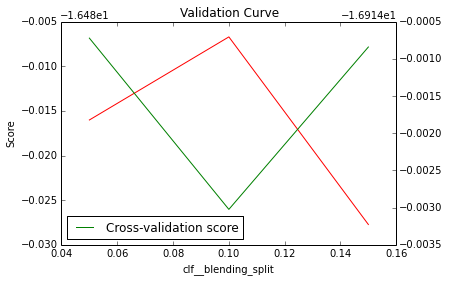

In [10]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# Sweep alpha = np.arange(0.5, 1.6, 0.1)
# 100% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.twinx()
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

# Generate submission

In [9]:
pip.fit(X, y)

Pipeline(steps=[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(RandomForestRegressor(boo...gression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
         blending_split=0.1))])

In [10]:
test = pd.read_csv('../data/test.csv')
test_withRef = test[test['Ref'].notnull()]
test_withRef_comb = test_withRef.groupby('Id').agg(['mean','std','median','count','min', 'max'])
test_withRef_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(test_withRef_comb.columns.values)]
test_X = test_withRef_comb.loc[:, 'minutes_past_mean':'Kdp_5x5_90th_max']  # NOTE: used range slicing on column
test_y_predict = 10**pip.predict(X=test_X)-1

In [11]:
# Ref-samples
test_result_withRef = pd.DataFrame()
test_result_withRef['Id'] = test_withRef_comb.index
test_result_withRef['Expected'] = test_y_predict
# All-samples
test_result = pd.DataFrame()
test_result['Id'] = test['Id'].unique()
# Merge and set Non-Ref samples to -1
test_result = pd.merge(test_result, test_result_withRef, how='left', on=['Id'], sort=True)
test_result.loc[test_result['Expected'].isnull(), 'Expected'] = -1
# Write file
datetime_str = time.strftime('%Y%m%d_%H%M%S')
test_result.to_csv('../data/result_'+datetime_str+'.csv', index=False)
print '../data/result_'+datetime_str+'.csv'

../data/result_20151125_142147.csv
